In [93]:
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib inline
%matplotlib notebook

In [97]:
def parse_attr_col(row):
    attr_dict = json.loads(row["attribute"])
    return {
        "seqid": row["seqid"],
        "uniformity_std": attr_dict["uniformity_std"],
        "phylo_diff": attr_dict["phylo_diff"],
        "ORF_l": row["end"] - row["start"] + 1,
        "representation": attr_dict["representation"],
        # "relative_median_btax_dist": attr_dict["norm_median_btax_dist"],###
        "relative_median_btax_dist": attr_dict["relative_median_btax_dist"]
    }


gtf_df = pd.read_csv("NC_000913.fasta.gtf", sep="\t")
gtf_df = gtf_df.merge(pd.DataFrame(list(gtf_df.apply(parse_attr_col, axis=1))))
gtf_df["representation"][gtf_df["representation"] <= 0.0] = np.nan 
gtf_df["representation"] = 1.0 / gtf_df["representation"] - 1.0
# gtf_df["uniformity_std"][gtf_df["uniformity_std"] == np.inf] = np.nan###
gtf_df["uniformity_std"][gtf_df["uniformity_std"] <= 0.0] = np.nan
gtf_df["uniformity_std"] = 1.0 / gtf_df["uniformity_std"]

nona_gtf_df = gtf_df.dropna()

/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
nona_gtf_df.head(10)

,seqid,source,type,start,end,score,strand,frame,attribute,ORF_l,phylo_diff,relative_median_btax_dist,representation,uniformity_std
0,NC_000913.3|:c620-111,EAGLE,ORF,111,620,-,-,.,"{""phylo_diff"": 0.625, ""relative_mean_ORF_dist""...",510,0.625000,4.910910,0.181818,3.181981
1,NC_000913.3|:c363-136,EAGLE,ORF,136,363,-,-,.,"{""phylo_diff"": 0.5, ""relative_mean_ORF_dist"": ...",228,0.500000,0.000180,1.600000,0.300803
2,NC_000913.3|:c463-233,EAGLE,ORF,233,463,-,-,.,"{""phylo_diff"": 0.6, ""relative_mean_ORF_dist"": ...",231,0.600000,4.246591,0.625000,0.257663
3,NC_000913.3|:292-2796,EAGLE,ORF,292,2796,-,+,.,"{""phylo_diff"": 0.4, ""relative_mean_ORF_dist"": ...",2505,0.400000,3.618361,0.000000,0.495774
4,NC_000913.3|:c747-520,EAGLE,ORF,520,747,-,-,.,"{""phylo_diff"": 0.42857142857142855, ""relative_...",228,0.428571,9.079483,0.300000,0.784063
5,NC_000913.3|:c987-751,EAGLE,ORF,751,987,-,-,.,"{""phylo_diff"": 0.2857142857142857, ""relative_m...",237,0.285714,11.063984,0.300000,0.619059
6,NC_000913.3|:c1120-908,EAGLE,ORF,908,1120,-,-,.,"{""phylo_diff"": 0.16666666666666666, ""relative_...",213,0.166667,9.416037,0.444444,0.909398
7,NC_000913.3|:c1245-991,EAGLE,ORF,991,1245,-,-,.,"{""phylo_diff"": 0.5714285714285714, ""relative_m...",255,0.571429,11.752501,0.300000,0.739830
8,NC_000913.3|:c1469-1203,EAGLE,ORF,1203,1469,-,-,.,"{""phylo_diff"": 0.5714285714285714, ""relative_m...",267,0.571429,4.142883,0.300000,0.444478
9,NC_000913.3|:c2172-1948,EAGLE,ORF,1948,2172,-,-,.,"{""phylo_diff"": 0.42857142857142855, ""relative_...",225,0.428571,10.217761,0.300000,0.637289


Text(0,0.5,'ORFs number')

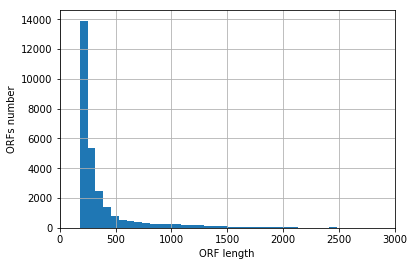

In [65]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["ORF_l"])).hist(bins=100);
ax.set_xlabel("ORF length")
ax.set_xlim(0, 3000)
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

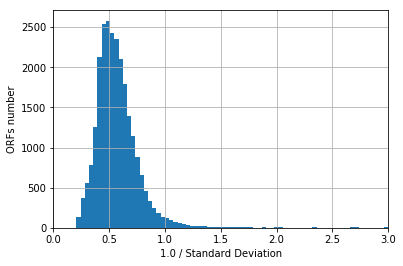

In [66]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["uniformity_std"])).hist(bins=250)
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_xlim(0, 3)
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

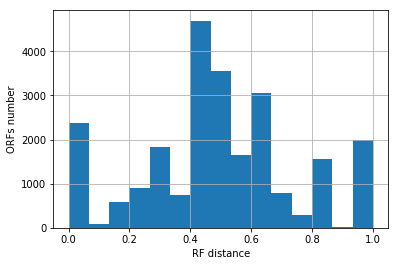

In [69]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["phylo_diff"])).hist(bins=15);
ax.set_xlabel("RF distance")
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

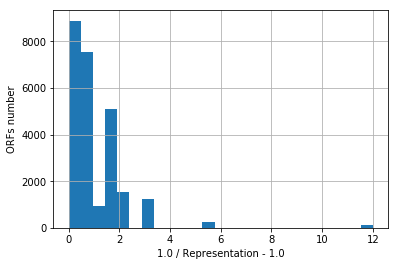

In [77]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["representation"])).hist(bins=25);
ax.set_xlabel("1.0 / Representation - 1.0")
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

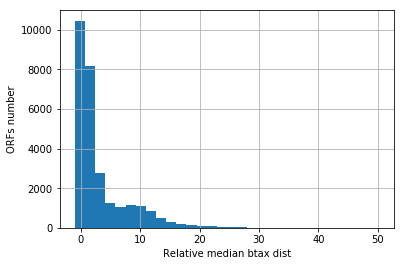

In [73]:
ax = pd.Series(filter(lambda x: not np.isnan(x), gtf_df["relative_median_btax_dist"])).hist(bins=30);
ax.set_xlabel("Relative median btax dist")
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


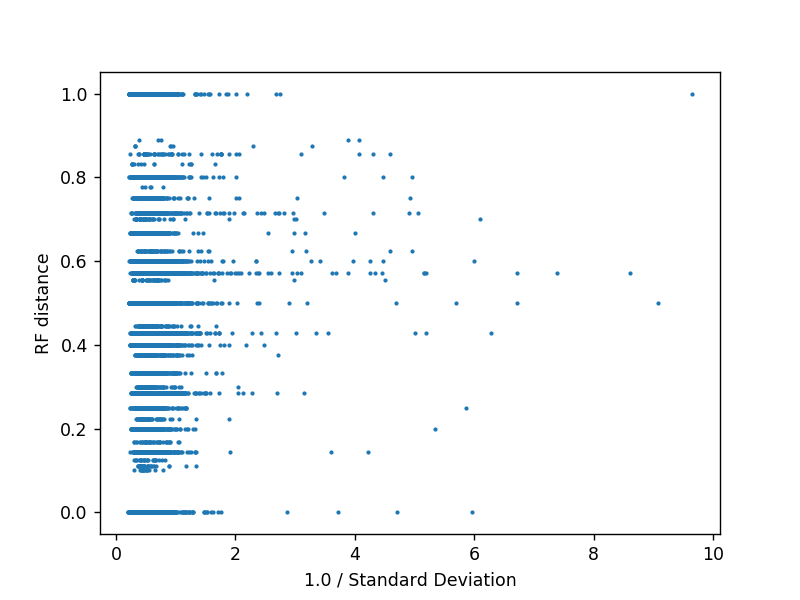

Text(0,0.5,'RF distance')

In [104]:
plt.scatter(x=nona_gtf_df["uniformity_std"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("RF distance")

<IPython.core.display.Javascript object>


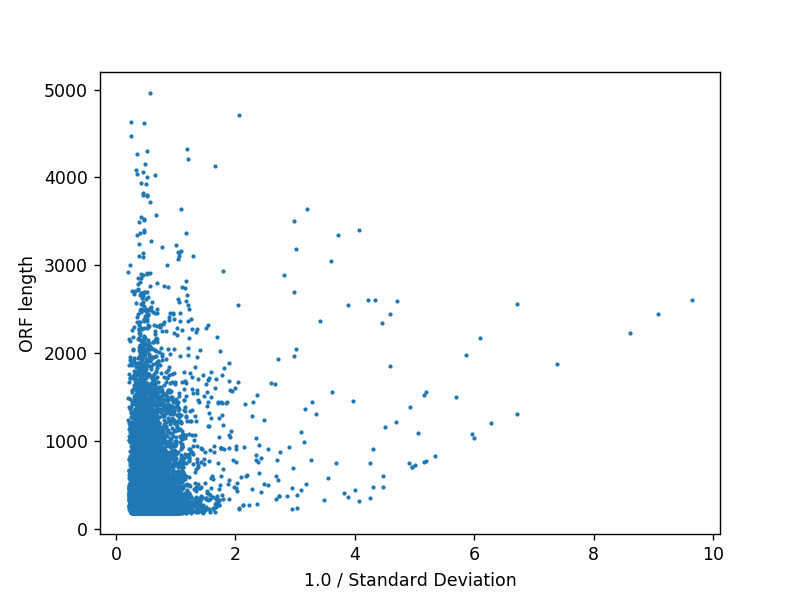

Text(0,0.5,'ORF length')

In [102]:
plt.scatter(x=gtf_df["uniformity_std"],
            y=gtf_df["ORF_l"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("ORF length")

<IPython.core.display.Javascript object>


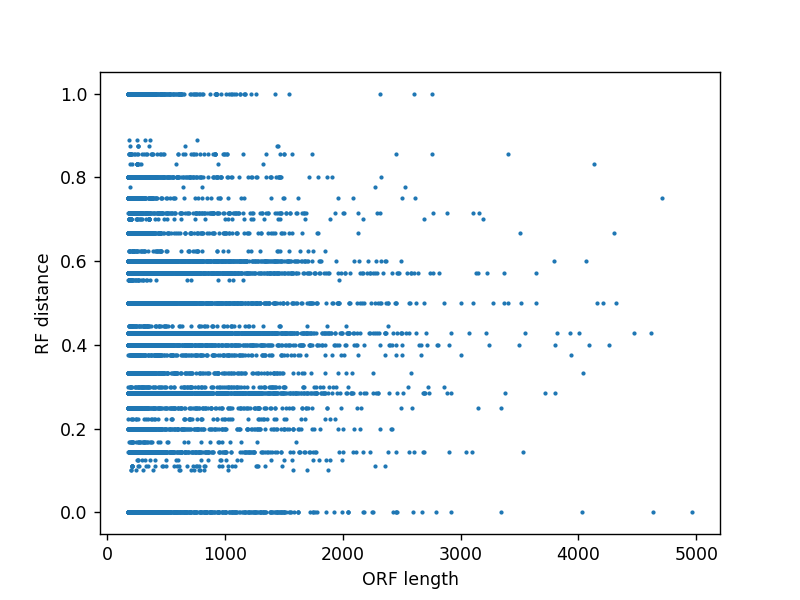

Text(0,0.5,'RF distance')

In [107]:
plt.scatter(x=nona_gtf_df["ORF_l"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("ORF length")
plt.ylabel("RF distance")

<IPython.core.display.Javascript object>


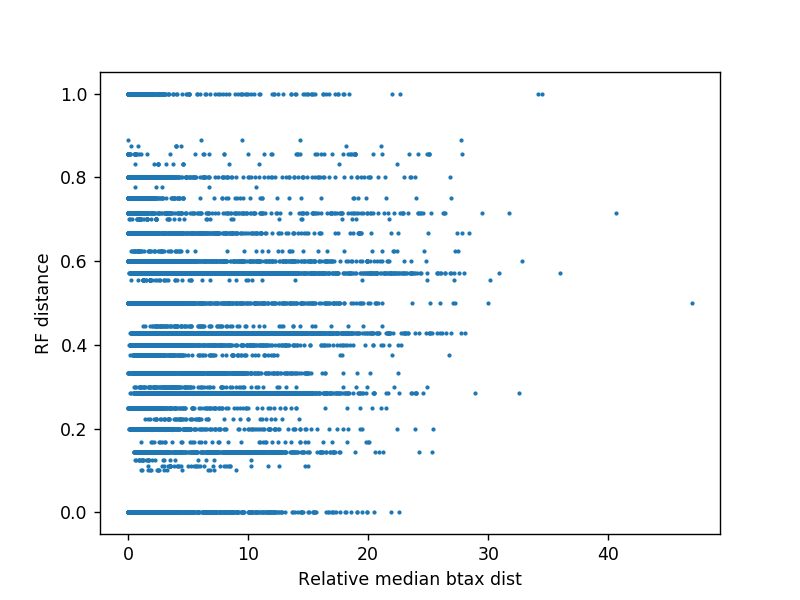

Text(0,0.5,'RF distance')

In [105]:
plt.scatter(x=nona_gtf_df["relative_median_btax_dist"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("Relative median btax dist")
plt.ylabel("RF distance")

<IPython.core.display.Javascript object>


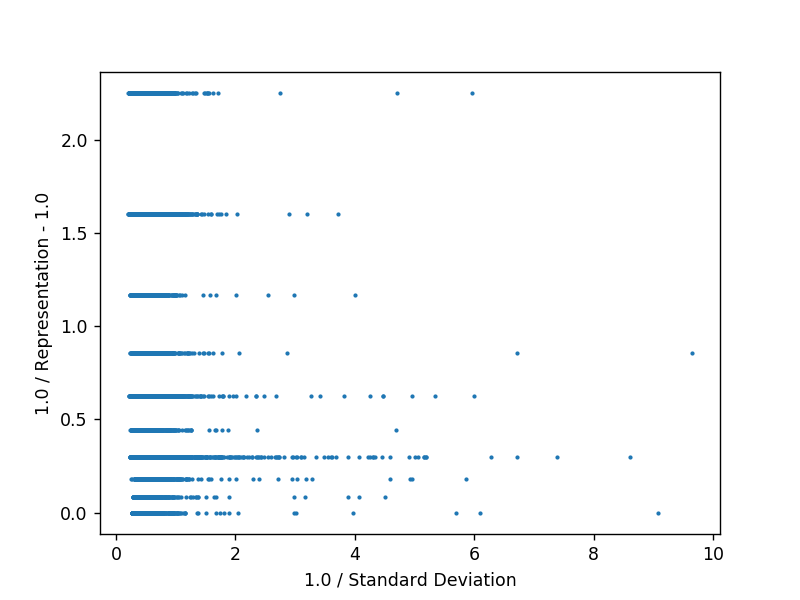

Text(0,0.5,'1.0 / Representation - 1.0')

In [100]:
plt.scatter(x=nona_gtf_df["uniformity_std"],
            y=nona_gtf_df["representation"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("1.0 / Representation - 1.0")

<IPython.core.display.Javascript object>


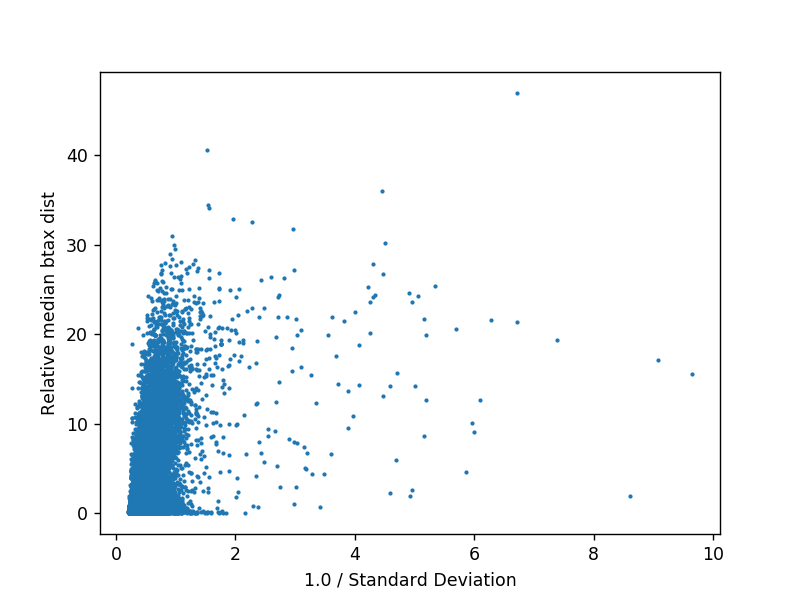

Text(0,0.5,'Relative median btax dist')

In [95]:
plt.scatter(x=gtf_df["uniformity_std"],
            y=gtf_df["relative_median_btax_dist"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("Relative median btax dist")

<IPython.core.display.Javascript object>


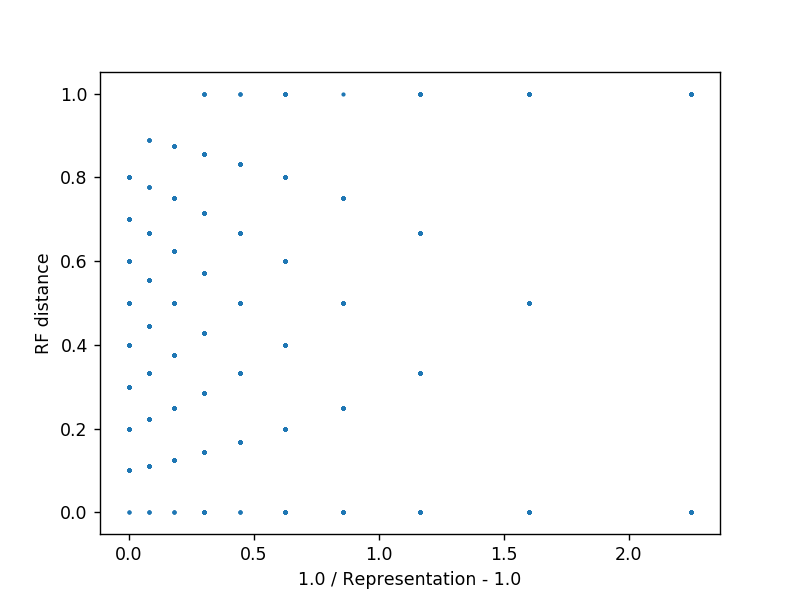

Text(0,0.5,'RF distance')

In [98]:
plt.scatter(x=nona_gtf_df["representation"],
            y=nona_gtf_df["phylo_diff"],
            s=2)
plt.xlabel("1.0 / Representation - 1.0")
plt.ylabel("RF distance")

<IPython.core.display.Javascript object>


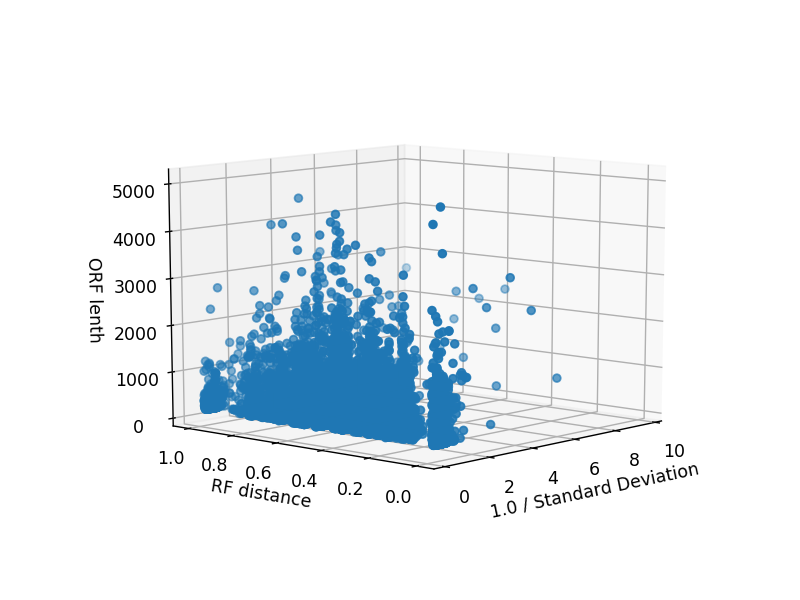

In [108]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nona_gtf_df["uniformity_std"],
           nona_gtf_df["phylo_diff"],
           nona_gtf_df["ORF_l"])
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_ylabel("RF distance")
ax.set_zlabel("ORF lenth")
plt.show()

(2372, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


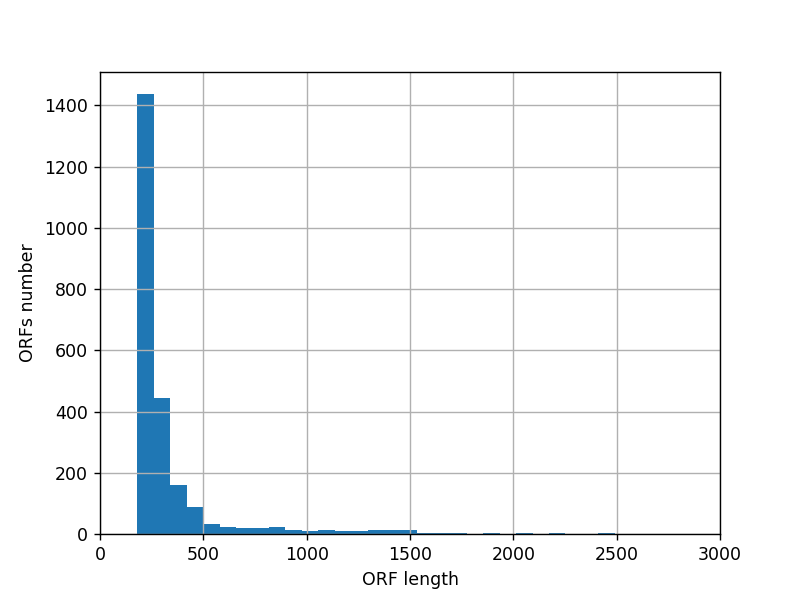

Text(0,0.5,'ORFs number')

In [109]:
gtf_df_filt1 = nona_gtf_df[nona_gtf_df["phylo_diff"] < 0.05][nona_gtf_df["uniformity_std"] < 2.0]
print(gtf_df_filt1.shape)
ax = gtf_df_filt1["ORF_l"].hist(bins=60)
ax.set_xlabel("ORF length")
ax.set_xlim(0, 3000)
ax.set_ylabel("ORFs number")

<IPython.core.display.Javascript object>


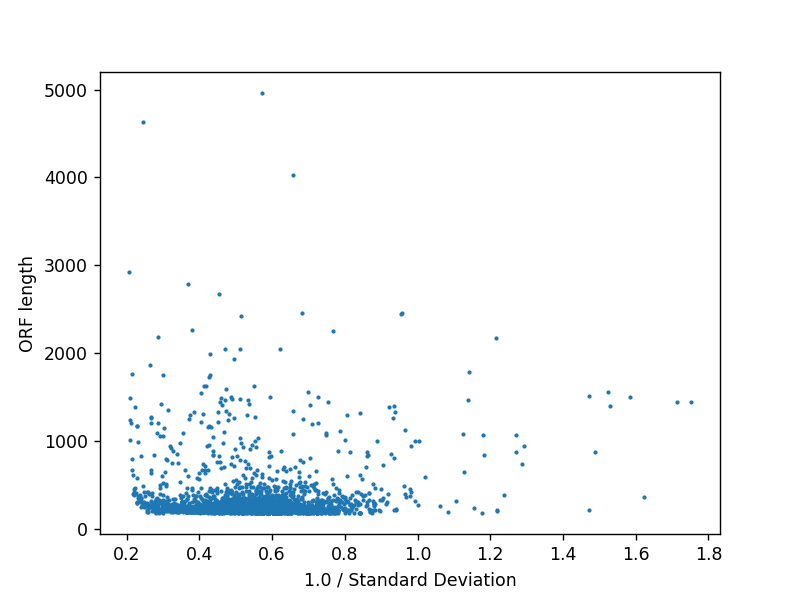

Text(0,0.5,'ORF length')

In [110]:
plt.scatter(x=gtf_df_filt1["uniformity_std"],
            y=gtf_df_filt1["ORF_l"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("ORF length")

Text(0,0.5,'1.0 / Representation - 1.0')

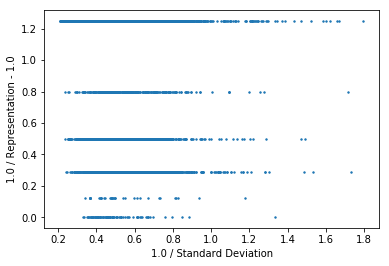

In [27]:
plt.scatter(x=gtf_df_filt["uniformity_std"],
            y=gtf_df_filt["representation"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("1.0 / Representation - 1.0")

(1080, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


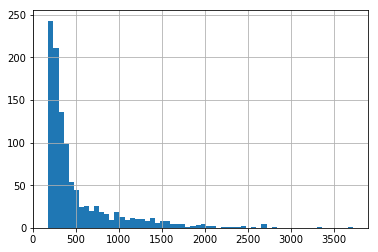

In [58]:
gtf_df_filt2 = gtf_df_filt[gtf_df_filt["representation"] < 0.4][gtf_df_filt["uniformity_std"] <= 1.3]
print(gtf_df_filt2.shape)
gtf_df_filt2["ORF_l"].hist(bins=60)

Text(0,0.5,'Relative median btax dist')

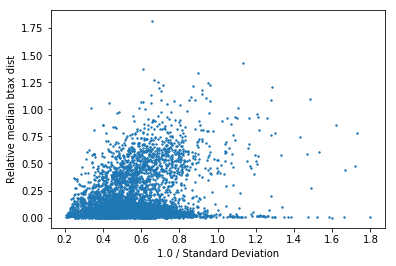

In [59]:
plt.scatter(x=gtf_df_filt["uniformity_std"],
            y=gtf_df_filt["relative_median_btax_dist"],
            s=2)
plt.xlabel("1.0 / Standard Deviation")
plt.ylabel("Relative median btax dist")

(447, 14)


/media/denis/Data/Data/Bioinf/Projects/Annotation/comparative/EAGLE_venv_lin/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


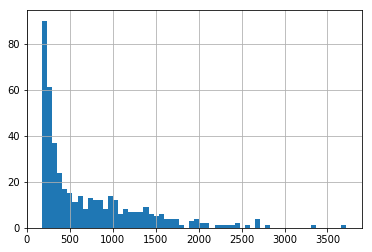

In [61]:
gtf_df_filt3 = gtf_df_filt2[gtf_df_filt["relative_median_btax_dist"] < 0.25][gtf_df_filt["uniformity_std"] <= 1.0]
print(gtf_df_filt3.shape)
gtf_df_filt3["ORF_l"].hist(bins=60)

<IPython.core.display.Javascript object>


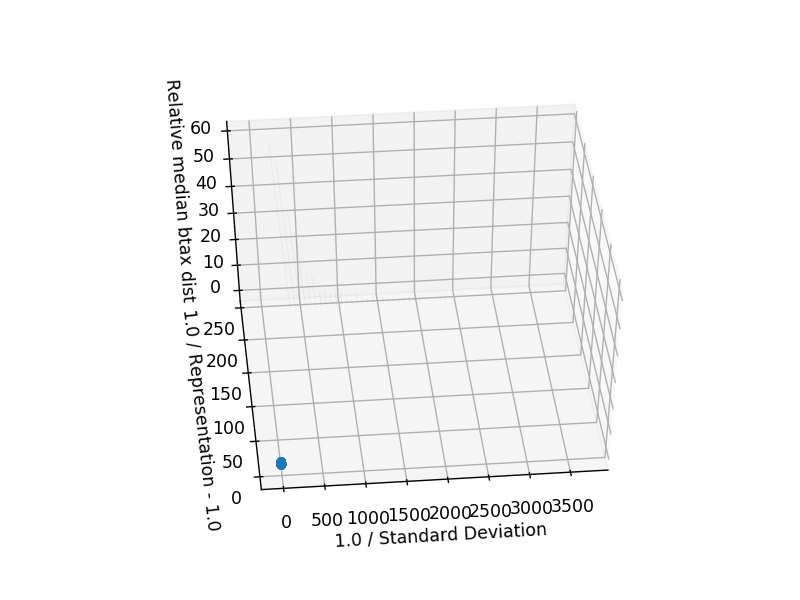

In [54]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(gtf_df_filt2["uniformity_std"],
           gtf_df_filt2["representation"],
           gtf_df_filt2["relative_median_btax_dist"])
ax.set_xlabel("1.0 / Standard Deviation")
ax.set_ylabel("1.0 / Representation - 1.0")
ax.set_zlabel("Relative median btax dist")
plt.show()

In [19]:
1.0/ pd.Series([1,2,3,np.nan])

0    1.000000
1    0.500000
2    0.333333
3         NaN
dtype: float64